In [1]:
%pylab inline
from pygadgetreader import readsnap

Populating the interactive namespace from numpy and matplotlib


In [2]:
import weights

In [3]:
def all_host_particles(xyz, vxyz, pids, pot, mass, N_host_particles):
    """
    Function that return the host and the sat particles
    positions and velocities.

    Parameters:
    -----------
    xyz: snapshot coordinates with shape (n,3)
    vxys: snapshot velocities with shape (n,3)
    pids: particles ids
    Nhost_particles: Number of host particles in the snapshot
    Returns:
    --------
    xyz_mw, vxyz_mw, xyzlmc, vxyz_lmc: coordinates and velocities of
    the host and the sat.

    """
    sort_indexes = np.sort(pids)
    N_cut = sort_indexes[N_host_particles]
    host_ids = np.where(pids<N_cut)[0]
    return xyz[host_ids], vxyz[host_ids], pids[host_ids], pot[host_ids], mass[host_ids]

def energies(snap, rcut=0):
    """
    Paramters:
    ----------

    snap : string
        path and name of the snapshot

    rcut : int
        truncation radii (no trunction by default rcut=0)


    Returns:
    --------
    Distances (rr)
    Kinetic energy (Ekk)
    Potential (MW_pot)
    Ids (MW_ids)
    Mass (MW_mass)
    Pos (MW_pos)
    Vel (MW_vel)

    """

    MW_pos= readsnap(snap, 'pos', 'dm')
    MW_vel= readsnap(snap, 'vel', 'dm')
    MW_mass= readsnap(snap, 'mass', 'dm')
    MW_pot = readsnap(snap, 'pot', 'dm') # in units of km^2/s^2
    MW_ids = readsnap(snap, 'pid', 'dm')


    # Selecting MW particles
    N_host_particles = 97000
    #MW_pos, MW_vel, MW_ids, MW_pot, MW_mass = all_host_particles(pp, vv, ids, Epp, massarr, N_host_particles)

    assert len(MW_ids)==N_host_particles, 'Error: something went wrong selecting the host particles'

    rr=np.sqrt(MW_pos[:,0]**2+MW_pos[:,1]**2+MW_pos[:,2]**2)


    if rcut>0:
        r_cut = np.where((rr<rcut))[0]

        rr = rr[r_cut]
        MW_pos = MW_pos[r_cut]
        MW_vel = MW_vel[r_cut]
        MW_mass = MW_mass[r_cut]
        MW_pot = MW_pot[r_cut]
        MW_ids = MW_ids[r_cut]

    v2=MW_vel[:,0]**2+MW_vel[:,1]**2+MW_vel[:,2]**2
    Ekk=0.5*v2

    return rr, Ekk, MW_pot, MW_ids, MW_mass, MW_pos, MW_vel

In [4]:
def chervin_original(r, Ek, Ep, partID, m, bsize, N_Eb, stellar_mass, bb):
    G = 4.30071e-6
    stellar_mass=stellar_mass*1e10
    Ep=Ep-G*m*np.size(r)/np.max(r) #correction term 
    E=Ek+Ep

    shift_energy = -np.min(Ep)
    E += shift_energy
    Ep += shift_energy
    
    #I chose 300 because this code was initially used for cosmological halos which were way too messed up beyond 300 kpc  
    w=np.where((r <300) & (r!=r[0])) 
    r=r[w]
    Ep=Ep[w]
    Ek=Ek[w]
    E=E[w]
    partID=partID[w]
    
    # Histogram of radius to smooth the potential Phi(r)
    #  - spherical averaging for triaxial halos for Laporte 2013
    #
    MIN,MAX = np.min(np.log10(r)), np.max(np.log10(r))
    Nbins= (MAX-MIN)/bsize    
    histo_rad,redges=np.histogram(np.log10(r), bins = np.linspace(MIN, MAX, Nbins))
    rbins=np.ndarray(shape=np.size(redges)-1, dtype=float)    
    for i in range(1,np.size(redges)):
        rbins[i-1]=redges[i-1]-(redges[i]-redges[i-1])/2.
    rbins=10**rbins    
    nn=np.size(rbins)
    binsize_r=np.ndarray(shape=nn, dtype=float)   
    #     binsize_r is evaluated here for g(E) calculation
    for j in range(0,nn): 
        binsize_r[j]=10**redges[j+1]-10**redges[j]

    #TRACER PARAMETRISATION
    ##bb=0.5 #scale radius
    #nu_tracer=(3.0/(4.0*np.pi*bb**3))*(1.0+(rbins/bb)**2)**(-2.5) # PLUMMER
    nu_tracer=(1*bb/(2.0*np.pi*rbins))/(bb+rbins)**3 # HERNQUIST
    
    #Need to do the reverse indices here - 
    pot2=np.ndarray(shape=np.size(histo_rad), dtype=float)
    for j in range(0, np.size(redges)-1):
        wbin=np.where((np.log10(r)>=redges[j]) & (np.log10(r)<redges[j+1]))
        if(np.size(wbin)>0):
            pot2[j]=np.mean(Ep[wbin]) #reverse indices in IDL is much faster than this junk
    
    # forgot why I wanted more than 20 particles in the bins, maybe sth to do with gradient not working with missing data
    w=np.where(histo_rad>20.)
    rbins=rbins[w]
    binsize_r=binsize_r[w]
    nu_tracer=nu_tracer[w]
    pot2=pot2[w]
    pot2-=shift_energy
    psi2=(-1.0)*pot2
    E-=shift_energy
    epsilon=(-1.0)*E   

    #Fetching derivatives from the data necessary for the Eddington formula evalution
    dnu_dpsi=np.gradient(nu_tracer, psi2)
    dnu2_dpsi2=np.gradient(dnu_dpsi, psi2)
    
    #Binning Energy for g(E) and f(E) (f(epsilon)) calculations                                
    Histo_E, Edges = np.histogram(E, bins=N_Eb)
    Ebins=np.ndarray(shape=np.size(Histo_E), dtype=float)
    for i in range(1,np.size(Edges)):
        Ebins[i-1]=Edges[i-1]-(Edges[i]-Edges[i-1])/2.
        
    Histo_epsilon, epsdges = np.histogram(epsilon, bins=N_Eb)
    epsilon_bins=np.ndarray(shape=np.size(Histo_epsilon), dtype=float)
    for i in range(1,np.size(epsdges)):
        epsilon_bins[i-1]=epsdges[i-1]-(epsdges[i]-epsdges[i-1])/2.

        
    #Total N(E) differential energy distribution
    Histo_M=Histo_E*m/np.sqrt((Ebins[2]-Ebins[1])**2) 

    # EDDINGTON FORMULA --------------
    dpsi=np.ndarray(shape=np.size(psi2), dtype=float)
    for i in range (1, np.size(dpsi)):
        dpsi[i]=psi2[i]-psi2[i-1]
    distribution_function=np.ndarray(shape=np.size(epsilon_bins), dtype=float)
    for i in range(0,np.size(epsilon_bins)):
        w=np.where(psi2<epsilon_bins[i])[0]
        #x=np.min(w) #i don't think I use this anywhere
        eps=epsilon_bins[i]
        if (np.size(w)!=0):
            w=np.array(w)
            tot1=dpsi[w]
            #print(tot1)
            tot2=dnu2_dpsi2[w]
            tot3=np.sqrt(2.0*(eps-psi2[w]))
            print(eps, tot3)
            tot=tot1*tot2/tot3
            val=(1.0)/(np.sqrt(8.0)*np.pi**2)*np.sum(tot) #Arthur's eval as Sum (in sims no divergence due to res)
            #print val, i, "val, i"
            distribution_function[i]=val
        else:
            distribution_function[i]=0
            
    return dnu2_dpsi2, dpsi, psi, epsilon_bins, distribution_function 

In [5]:
rr, Ek, Ep, Mw_ids, MW_m, MW_p, MW_v = energies('../halos/LMC1_97K_vir_000', rcut=50)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass
Returning DM    Potential
Returning DM    Particle IDs


In [7]:
all_t = weights.weight_triaxial(rr, Ek, Ep, Mw_ids, MW_m[0], 0.05, 200, 1, 'Hernquist', [10])

In [7]:
dnu2_dpsi2_c, dpsi_c, psi_c, eps_bins_c, df_c = chervin_original(rr, Ek, Ep, Mw_ids, MW_m[0], 0.1, 100, 1, 10)

3002.41005859 [ 23.00322243]
3398.47619141 [ 36.34942239]
3794.54232422 [ 27.5972478   45.97186937]
4190.60845703 [ 39.41751326  53.90310788]
4586.67458984 [ 26.67244819  48.43420916  60.80852987]
4982.74072266 [ 38.77565935  56.01789788  67.0060413 ]
5378.80685547 [ 17.771456    47.91329694  62.69080593  72.67696909]
5774.87298828 [ 33.28598675  55.56812296  68.71877046  77.93634647]
6170.93912109 [ 43.59001238  62.28923306  74.2590175   82.86257519]
6567.00525391 [ 17.64301938  51.88662106  68.35262117  79.41368865  87.51193423]
6963.07138672 [ 33.2175917   59.02841444  73.92031579  84.25358278  91.92644287]
7359.13751953 [ 43.5378073   65.39484671  79.09706285  88.83016648  96.1384583 ]
7755.20365234 [  51.84277124   71.19422899   83.95521197   93.18224478  100.17352659]
8151.26978516 [  25.9401452    58.98987367   76.55553871   88.54721838   97.33993532
  104.05223542]
8547.33591797 [  38.27562408   65.36006014   81.56520565   92.91255108  101.32716947
  107.79146516]
8943.40205078

/home/xzk/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


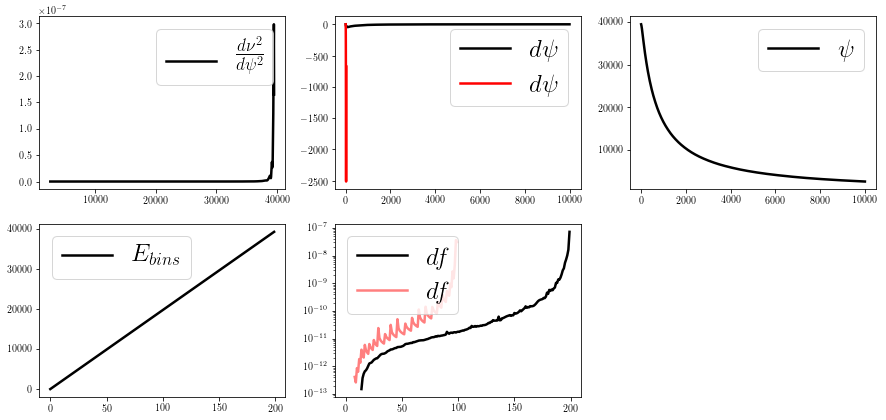

In [8]:
figure(figsize=(15, 7))

subplot(2, 3, 1)
plot(psi, dnu2_dpsi2, c='k', lw=2.5, label=r'$\frac{d \nu^2}{d \psi^2} $')
#plot(dnu2_dpsi2_c, c='r', lw=2.5, label=r'$\frac{d \nu^2}{d \psi^2} $')

legend(fontsize=25)

subplot(2, 3, 2)
plot( dpsi, c='k', lw=2.5, label=r'$d \psi$')
plot( dpsi_c, c='r', lw=2.5, label=r'$d \psi$')
legend(fontsize=25)

subplot(2, 3, 3)
plot( psi, c='k', lw=2.5, label=r'$\psi$')
#plot(eps_bins, psi_c, c='r', lw=2.5, label=r'$\psi$')
legend(fontsize=25)

subplot(2, 3, 4)
plot(eps_bins, c='k', lw=2.5, label='$E_{bins}$')
#plot(eps_bins_c, c='r', lw=2.5, label='$E_{bins}$')
legend(fontsize=25)

subplot(2, 3, 5)
semilogy( np.abs(df), c='k', lw=2.5, label='$df$')
semilogy( np.abs(df_c), c='r', lw=2.5, label='$df$', alpha=0.5)
legend(fontsize=25)


In [183]:
def potential_binning(pot, r, r_bins):
    pot_r = np.zeros(len(r_bins))
    for i in range(len(r_bins)-1):
        w = np.where((r<=r_bins[i+1])  & (r>r_bins[i]))[0]
        pot_r[i] = np.sum(pot[w])
    return pot_r

In [292]:
def eddington(psi, r, Ep, e, m, bb):
    """
    
    """
    G = 43007.1
    Ep=Ep-G*m*np.size(r)/np.max(r) #correction term     
    shift_energy = -np.min(Ep)
    
    
    rbins = np.arange(1, 50, 1)
    pot2 = potential_binning(Ep, r, rbins)
    pot2 -=shift_energy
    psi2=(-1.0)*pot2
    
    nu_tracer=(1*bb/(2.0*np.pi*rbins))/(bb+rbins)**3 # HERNQUIST
    
    dnu_dpsi=np.gradient(nu_tracer, psi2)
    dnu2_dpsi2=np.gradient(dnu_dpsi, psi2) 
    
    
    index_psi = np.argmin(np.abs(psi-psi2)) # assumption of this method
    #print(dnu2_dpsi2[index_psi])
    if  (psi>e):
        return 0
    else:
        df = 1/(np.sqrt(e-psi)) * dnu2_dpsi2[index_psi]
        #print(df)
        return df 

In [293]:
from scipy.integrate import quad

In [306]:
eddington(psi[10], rr, Ep, 40000, MW_m[0], 10)

5.1839787923802995e-21

In [307]:
df = []
for i in range(-20, 2000, 100):
    df.append(quad(eddington, 0, i, args=(rr, Ep, i, MW_m[0], 10))[0])

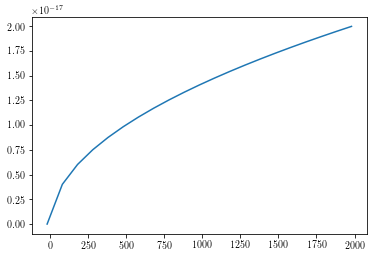

In [309]:
plot(np.arange(-20, 2000, 100), df)

In [300]:
df

[(4.493769936366856e-19, 1.5311971918791254e-19),
 (4.516182893041926e-18, 1.5388341329794813e-18),
 (6.3710184558200165e-18, 2.1708466848769657e-18),
 (7.796399451374576e-18, 2.6565278409344413e-18),
 (8.998767284822308e-18, 3.0662199872282913e-18),
 (1.0058418408844546e-17, 3.4272831587858004e-18),
 (1.1016612416182088e-17, 3.753776057640531e-18),
 (1.189788709684925e-17, 4.054059635887684e-18),
 (1.2718242237446462e-17, 4.333585625293758e-18),
 (1.3488797346367162e-17, 4.596142862463175e-18),
 (1.4217651778418133e-17, 4.8444911035721495e-18),
 (1.4910921847201493e-17, 5.0807144077391466e-18),
 (1.5573360542103465e-17, 5.306432298015926e-18),
 (1.620874846542261e-17, 5.522932968436707e-18),
 (1.6820151457592e-17, 5.731261066664438e-18),
 (1.741009659069498e-17, 5.9322776616306644e-18),
 (1.7980696080472623e-17, 6.126702465037829e-18),
 (1.8533736800206213e-17, 6.315144332120932e-18),
 (1.90707463938964e-17, 6.4981237889053515e-18),
 (1.9593043057710734e-17, 6.676089994626794e-18)]

In [ ]:
E = eddington(eps_bins, dpsi, dnu2_dpsi2, psi)

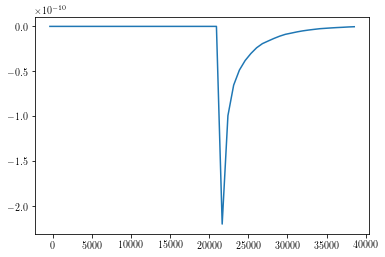

In [112]:
plot(eps_bins,E)

In [113]:
df = np.zeros(len(E))
for i in range(len(E)):
    df[i] = np.sum(E[:i])/(np.sqrt(8)*np.pi**2)
    

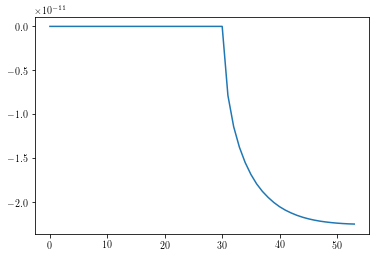

In [114]:
plot(df)

In [18]:
from scipy.interpolate import InterpolatedUnivariateSpline

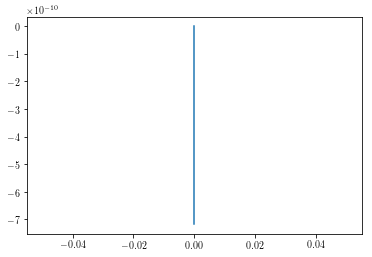

In [55]:
plot(ew,df_b)

In [23]:
df_b

array([  0.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [24]:
E

array([             nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,  -3.26108518e-10,
        -1.43241226e-10,  -8.25307654e-11,  -5.43821936e-11,
        -3.72468547e-11,  -2.62528904e-11,  -1.83333041e-11,
        -1.27059461e-11,  -8.43974477e-12,  -5.52958758e-12,
        -2.78420281e-12,  -1.42751616e-12])

In [51]:
x=np.linspace(0, 100, 100)

In [58]:
x[np.array([1, 2, 3, 4,])::]

TypeError: only integer scalar arrays can be converted to a scalar index